E:\Github\pneumonia_vs_normal_with_mlflow


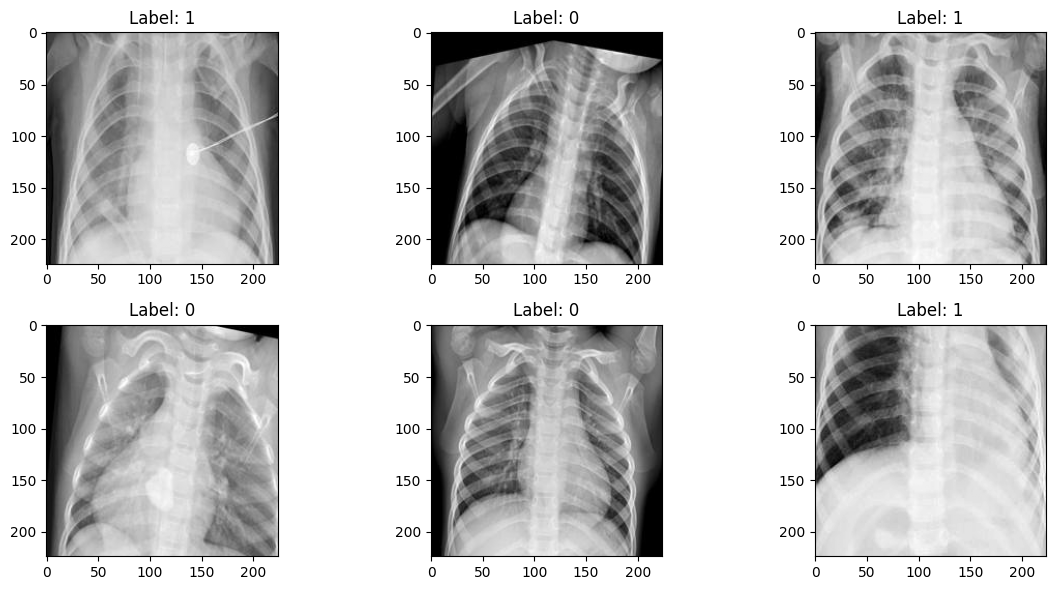

In [48]:
%run E:/Github/pneumonia_vs_normal_with_mlflow/notebooks/Training/Loading_data.ipynb

# Importing libraries

In [49]:
from torchvision import transforms, models
from torch import nn
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import joblib


# Identifying the model

In [50]:
chexnet = models.densenet121(weights= models.DenseNet121_Weights.IMAGENET1K_V1)
chexnet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Modfying the architechture so it can fit our model

In [51]:
chexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

chexnet.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)

chexnet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Using the GPU in our training process

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
chexnet = chexnet.to(device)

Using device: cuda


# Creating an EarlyStopping function that monitors the validation loss 

In [53]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Identifying our Optimizer & Loss parameter

In [64]:
# Optimizer
optimizer = torch.optim.Adam(chexnet.parameters(), lr=1e-4)

# Loss Function with class weights
loss = nn.CrossEntropyLoss()

early_stopping = EarlyStopping(patience=15, min_delta=0.001)

# Training Loop

In [65]:
import mlflow
import mlflow.pytorch
from tqdm import tqdm
from sklearn.metrics import f1_score

with mlflow.start_run():
    # Log static parameters
    mlflow.log_param("epochs", 128)
    mlflow.log_param("lr", optimizer.param_groups[0]['lr'])
    mlflow.log_param("batch_size", train_loader.batch_size)
    mlflow.log_param("model", "DenseNet121 (CheXNet variant)")

    for epoch in tqdm(range(128)):
        # Training
        chexnet.train()
        running_loss = 0.0
        train_corrects = 0
        train_samples = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            preds = chexnet(images)
            loss_val = loss(preds, labels)
            loss_val.backward()
            optimizer.step()

            running_loss += loss_val.item()

            _, predicted = torch.max(preds, 1)
            train_corrects += (predicted == labels).sum().item()
            train_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader)

        # Validation
        chexnet.eval()
        val_corrects = 0
        val_samples = 0
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                preds = chexnet(images)
                loss_val = loss(preds, labels)
                val_loss += loss_val.item()

                _, predicted = torch.max(preds, 1)
                val_corrects += (predicted == labels).sum().item()
                val_samples += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_corrects / val_samples
        overall_acc = (train_corrects + val_corrects) / (train_samples + val_samples)
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Log metrics to MLflow
        mlflow.log_metric("train_loss", float(epoch_loss), step=epoch)
        mlflow.log_metric("val_loss", float(val_loss), step=epoch)
        mlflow.log_metric("val_accuracy", float(val_acc), step=epoch)
        mlflow.log_metric("overall_accuracy", float(overall_acc), step=epoch)
        mlflow.log_metric("f1_score", float(f1), step=epoch)

        print(f"Epoch [{epoch+1}/128], "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_acc:.4f}, "
              f"Overall Accuracy: {overall_acc:.4f}, "
              f"F1 Score: {f1:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Log final model
    mlflow.pytorch.log_model(chexnet, "chexnet_model")


  1%|          | 1/128 [01:14<2:38:07, 74.71s/it]

Epoch [1/128], Train Loss: 0.0174, Val Loss: 0.5293, Val Accuracy: 0.9375, Overall Accuracy: 0.9941, F1 Score: 0.9373


  2%|▏         | 2/128 [02:30<2:38:36, 75.53s/it]

Epoch [2/128], Train Loss: 0.0124, Val Loss: 0.8120, Val Accuracy: 0.6250, Overall Accuracy: 0.9948, F1 Score: 0.5636


  2%|▏         | 3/128 [03:44<2:36:04, 74.92s/it]

Epoch [3/128], Train Loss: 0.0131, Val Loss: 0.0614, Val Accuracy: 1.0000, Overall Accuracy: 0.9952, F1 Score: 1.0000


  3%|▎         | 4/128 [04:57<2:32:36, 73.84s/it]

Epoch [4/128], Train Loss: 0.0041, Val Loss: 0.3015, Val Accuracy: 0.8750, Overall Accuracy: 0.9985, F1 Score: 0.8750


  4%|▍         | 5/128 [06:09<2:29:53, 73.12s/it]

Epoch [5/128], Train Loss: 0.0084, Val Loss: 1.2307, Val Accuracy: 0.5000, Overall Accuracy: 0.9971, F1 Score: 0.3333


  5%|▍         | 6/128 [07:21<2:28:06, 72.84s/it]

Epoch [6/128], Train Loss: 0.0095, Val Loss: 0.3561, Val Accuracy: 0.8750, Overall Accuracy: 0.9969, F1 Score: 0.8730


  5%|▌         | 7/128 [08:33<2:26:25, 72.61s/it]

Epoch [7/128], Train Loss: 0.0008, Val Loss: 0.2921, Val Accuracy: 0.8750, Overall Accuracy: 0.9996, F1 Score: 0.8730


  6%|▋         | 8/128 [09:45<2:24:41, 72.34s/it]

Epoch [8/128], Train Loss: 0.0002, Val Loss: 0.3667, Val Accuracy: 0.7500, Overall Accuracy: 0.9996, F1 Score: 0.7333


  7%|▋         | 9/128 [10:57<2:23:14, 72.22s/it]

Epoch [9/128], Train Loss: 0.0001, Val Loss: 0.3566, Val Accuracy: 0.8125, Overall Accuracy: 0.9997, F1 Score: 0.8057


  8%|▊         | 10/128 [12:09<2:21:51, 72.13s/it]

Epoch [10/128], Train Loss: 0.0001, Val Loss: 0.4062, Val Accuracy: 0.7500, Overall Accuracy: 0.9996, F1 Score: 0.7333


  9%|▊         | 11/128 [13:20<2:20:13, 71.91s/it]

Epoch [11/128], Train Loss: 0.0000, Val Loss: 0.2112, Val Accuracy: 0.9375, Overall Accuracy: 0.9999, F1 Score: 0.9373


  9%|▉         | 12/128 [14:35<2:20:40, 72.77s/it]

Epoch [12/128], Train Loss: 0.0000, Val Loss: 0.2961, Val Accuracy: 0.8750, Overall Accuracy: 0.9998, F1 Score: 0.8730


 10%|█         | 13/128 [15:49<2:20:10, 73.14s/it]

Epoch [13/128], Train Loss: 0.0000, Val Loss: 0.2282, Val Accuracy: 0.8750, Overall Accuracy: 0.9998, F1 Score: 0.8730


 11%|█         | 14/128 [17:05<2:20:51, 74.14s/it]

Epoch [14/128], Train Loss: 0.0000, Val Loss: 0.2876, Val Accuracy: 0.9375, Overall Accuracy: 0.9999, F1 Score: 0.9373


 12%|█▏        | 15/128 [18:21<2:20:21, 74.53s/it]

Epoch [15/128], Train Loss: 0.0000, Val Loss: 0.2757, Val Accuracy: 0.8750, Overall Accuracy: 0.9998, F1 Score: 0.8730


 12%|█▎        | 16/128 [19:27<2:14:22, 71.99s/it]

Epoch [16/128], Train Loss: 0.0289, Val Loss: 0.3892, Val Accuracy: 0.8750, Overall Accuracy: 0.9898, F1 Score: 0.8730


 13%|█▎        | 17/128 [20:34<2:10:34, 70.58s/it]

Epoch [17/128], Train Loss: 0.0232, Val Loss: 0.1475, Val Accuracy: 0.8750, Overall Accuracy: 0.9923, F1 Score: 0.8730


 13%|█▎        | 17/128 [21:41<2:21:38, 76.56s/it]
2025/05/21 19:07:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch [18/128], Train Loss: 0.0086, Val Loss: 0.0695, Val Accuracy: 1.0000, Overall Accuracy: 0.9971, F1 Score: 1.0000
Early stopping triggered at epoch 18


2025/05/21 19:07:29 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/21 19:07:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [67]:
mlflow.end_run()

# Evaluating my architecture

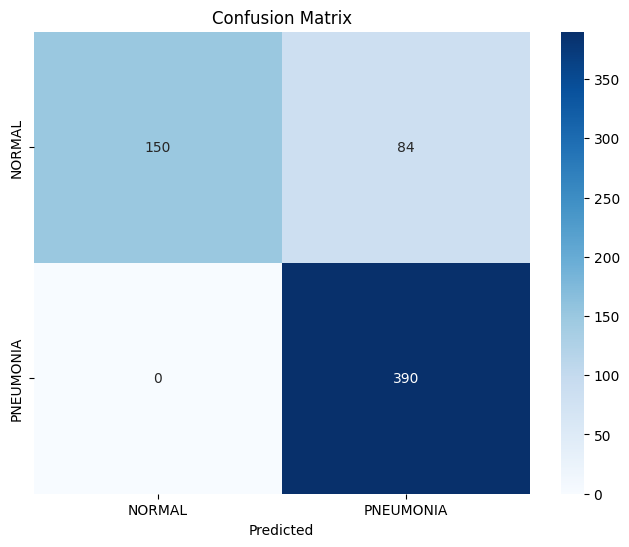

              precision    recall  f1-score   support

      NORMAL       1.00      0.64      0.78       234
   PNEUMONIA       0.82      1.00      0.90       390

    accuracy                           0.87       624
   macro avg       0.91      0.82      0.84       624
weighted avg       0.89      0.87      0.86       624



In [68]:
from sklearn.metrics import classification_report, confusion_matrix

chexnet.eval()
all_preds = []
all_labels = []

label_encoder = joblib.load(r'E:\Github\pneumonia_vs_normal_with_mlflow\label_encoder.pkl')

with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = chexnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert numeric labels back to original class names
true_labels = label_encoder.inverse_transform(all_labels)
pred_labels = label_encoder.inverse_transform(all_preds)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.show()

# Classification report with readable labels
print(classification_report(true_labels, pred_labels))


In [69]:
torch.save(chexnet.state_dict(), r'E:\Github\pneumonia_vs_normal_with_mlflow\models\densenet121_binary_classification.pth')
